In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import torch, torch.nn as nn, torch.nn.functional as F
from torch import tensor
from torch.utils.data import DataLoader
from torcheval.metrics import MulticlassAccuracy
import sys, traceback, gc
import fastcore.all as fc
from functools import partial

from miniai.learner import *
from miniai.hooks import *
from miniai.custom_modules import conv

sns.set()

In [3]:
data = pd.read_csv('data/fashion_mnist/train.csv')

In [4]:
X_train = tensor(data.iloc[:50000, 1:].values)
y_train = tensor(data.iloc[:50000, 0].values)
X_valid = tensor(data.iloc[50000:, 1:].values)
y_valid = tensor(data.iloc[50000:, 0].values)

In [5]:
class FashionDataset(Dataset):
    def __init__(self, x, y):
        self.x = (x - x.mean([1, 2, 3], keepdim=True)) / x.std([1, 2, 3], keepdim=True)
        self.y = y

In [6]:
dset_train = FashionDataset((X_train/255. ).view(-1, 1, 28, 28), y_train)
dset_valid = FashionDataset((X_valid/255. ).view(-1, 1, 28, 28), y_valid)

In [7]:
dl_train = DataLoader(dset_train, batch_size=128, shuffle=True, num_workers=4)
dl_valid = DataLoader(dset_valid, batch_size=len(dset_valid), shuffle=False,  num_workers=4)

In [8]:
dls = DataLoaders(dl_train, dl_valid)

In [9]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

<br>**Model**

In [10]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): nn.init.kaiming_normal_(m.weight, a=leaky)

In [12]:
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='tab:grey', linewidth=0.6)
    plt.axvline(x=0, color='tab:grey', linewidth=0.6)
    plt.show()

In [13]:
#|export
class GeneralReLU(nn.Module):
    def __init__(self, sub=None, leaky=None, maxv=None): 
        super().__init__()
        self.leaky = leaky; self.sub = sub; self.maxv = maxv
    def forward(self, x):
        x = F.leaky_relu(x, self.leaky) if (self.leaky != None) else F.relu(x)
        if self.sub != None: x -= self.sub
        if self.maxv != None: x.clamp_max_(self.maxv)
        return x

In [14]:
class LayerNorm(nn.Module):
    def __init__(self, eps=1e-2): super().__init__(); self.eps = eps
    def forward(self, x):
        #with torch.no_grad():
        m = x.mean([1, 2, 3], keepdim=True); std = x.std([1, 2, 3], keepdim=True)
        x = (x - m) / (std+self.eps)
        return x

In [15]:
act_func = GeneralReLU(sub=0.4, leaky=0.1)
model = nn.Sequential(
    conv(1, 8, act=act_func), #14×14
    nn.BatchNorm2d(8),
    conv(8, 16, act=act_func), #7×7
    nn.BatchNorm2d(16),
    conv(16, 32, act=act_func), #4×4
    nn.BatchNorm2d(32),
    conv(32, 64, act=act_func), #2×2
    conv(64, 10, act=None), #1×1
    nn.Flatten(),
)

In [16]:
model = model.apply(partial(init_weights, leaky=0.1))

In [19]:
metrics = MetricCB(accuracy=MulticlassAccuracy())
learn = TrainLearner(dls, model, F.cross_entropy, torch.optim.SGD, 
                cbs=[ProgressCB(), metrics])

In [20]:
with Hooks(model, append_stats) as hooks:
    learn.fit(3, 1e-1)

epoch,train_loss,valid_loss,accuracy
0,0.519,0.411,0.846
1,0.368,0.364,0.869
2,0.326,0.352,0.872


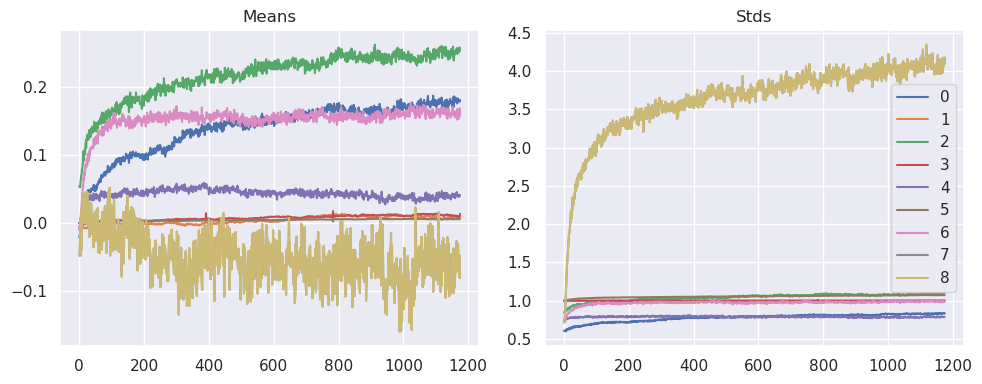

In [21]:
hooks.plot_means_stds()

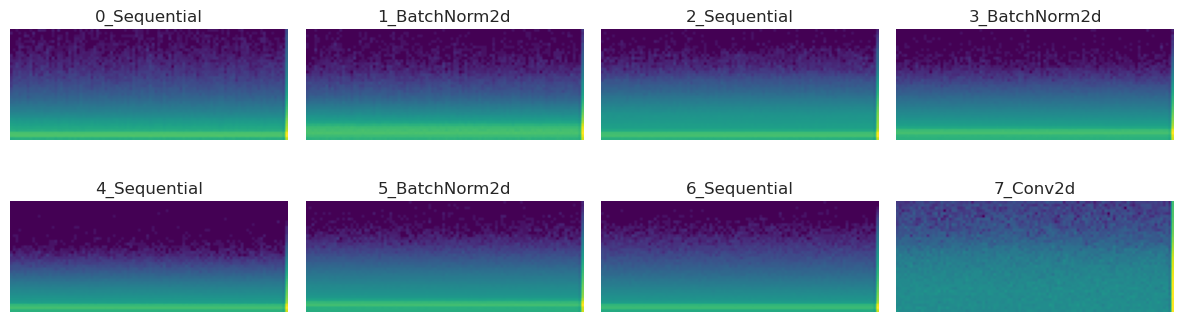

In [22]:
hooks.plot_acts(ls=range(8), rng=[-100, None])

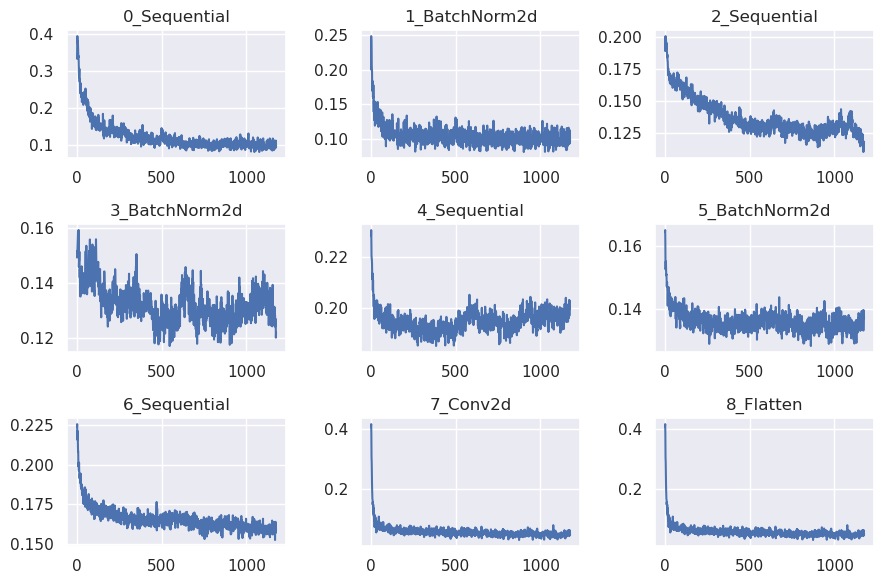

In [23]:
hooks.plot_dead_charts()

In [24]:
import nbdev; nbdev.nbdev_export()